# Workshop 1 - 2D Collision Avoidance Using Reinforcement Learning

<b>Project : MLPro - The integrative middleware framework for standardized machine learning</b> <br>
<b>Package : [mlpro_int_sb3](https://mlpro-int-sb3.readthedocs.io/en/latest/)</b> <br>
<b>Module : [howto_rl_env_003_train_agent_with_sb3_policy_on_2D_collision_avoidance_environment.py](https://github.com/fhswf/MLPro-Int-SB3/blob/main/test/howtos/environment/howto_rl_env_003_train_agent_with_sb3_policy_on_2D_collision_avoidance_environment.py)</b><br>
<b>Version : 1.0.0</b>

## Introduction of the Environment

In this workshop, we aim to address a basic 2D collision avoidance problem using reinforcement learning. Details about the environment can be found at the following link: [2D Collision Detection Environment](https://mlpro.readthedocs.io/en/latest/content/03_machine_learning/mlpro_rl/sub/env/pool/2Dcollisiondetection.html).

Initially, we will work with a setup involving 5 nodes, which include an initial node, a target node, and 2 controllable nodes. The obstacle remains static, while the target node can move among 4 different positions. The action space is constrained within the range of [-0.05, 0.05]. Before proceeding, you should be able to answer the following questions:
1. What are the states?
2. What is the action?
3. What are the objectives of the RL training?

## Tasks Descriptions
1. **Reward Shaping**: Developing a reward function to steer the RL agent towards desired behaviors more effectively by offering intermediate rewards or penalties.
2. **Policy Selection**: Choosing from three different RL algorithms, namely PPO, A2C, and DDPG.
3. **Run RL Training**: Execute the RL training setup in MLPro and analyze the results. If the goals are not met, consider revisiting and adjusting the previous two tasks.

## Executable Code

### 0. Import the related modules
The task involves importing the necessary libraries and packages.

In [1]:
from pathlib import Path

import numpy as np

from mlpro.bf import Log
from mlpro.bf.plot import DataPlotting
from mlpro.bf.systems import State
from mlpro.bf.ml import Model

from mlpro.rl import *
from mlpro.rl.pool.envs.collisionavoidance_2D import DynamicTrajectoryPlanner

from stable_baselines3 import PPO, DDPG, A2C
from stable_baselines3.common.noise import NormalActionNoise

from mlpro_int_sb3.wrappers import WrPolicySB32MLPro
from mlpro_int_gymnasium.wrappers import WrEnvMLPro2GYM

### 1. Design your own reward function
Your first task is to create a reward function that assigns rewards and penalties to the agent for each iteration. You can design your reward function using the following three components:
1. Number of Collide Points (`number_of_collide_points`): This parameter measures the number of collision points with the obstacle.
2. Number of Collide Lines (`number_of_collide_lines`): This parameter tracks the number of collision lines with the obstacle.
3. Distance of the Trajectory (`distance`): This parameter calculates the distance of the trajectory from the starting node to the target node, including visits to all controllable nodes.

Then, the reward function should be stored in a variable named `total_rewards`.

Here is an example of a reward function: If there is a collision with lines or points, a penalty of 10 points is given, along with a penalty based on the trajectory distance. Conversely, if there are no collisions, a reward of 10 points is granted. The reward function is designed as follows:
```python
if number_of_collide_lines != 0 or number_of_collide_points != 0:
    total_rewards = -(10+distance)
else:
    total_rewards = 10
```

In [2]:
class MyDynamicTrajectoryPlanner(DynamicTrajectoryPlanner):
    
    def _compute_reward(self, p_state_old:State, p_state_new:State) -> Reward:
        
        number_of_collide_points = 0
        number_of_collide_lines = 0
        for _ in self.collide_point_list:
            number_of_collide_points += 1
        for _ in self.collide_line_list:
            number_of_collide_lines += 1

        distance = self._calc_distance()
        
        # Insert your reward function in this section
        if number_of_collide_lines != 0 or number_of_collide_points != 0:
            total_rewards = -(10+distance)
        else:
            total_rewards = 10
            
        reward = Reward()
        reward.set_overall_reward(total_rewards)
        
        return reward

### 2. RL policy selection
Your second task is to choose the most suitable RL algorithm. We provide three different algorithms from the Stable-Baselines3 (SB3) library, which is integrated with MLPro through a wrapper called MLPro-Int-SB3. The available algorithms are:
1. [Advantage Actor-Critic (A2C)](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html)
2. [Proximal Policy Optimization (PPO)](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)
3. [Deep Deterministic Policy Gradient (DDPG)](https://stable-baselines3.readthedocs.io/en/master/modules/ddpg.html)

We have provided default implementations for each algorithm, with standard parameter values already set. You can select an algorithm by placing the code for its initialization in the `ScenarioTrajectoryPlanning` Class. Below are the code snippets for each algorithm:
1. **A2C**
```python
policy_kwargs = dict(activation_fn=torch.nn.Tanh,
                      net_arch=dict(pi=[128, 128], vf=[128, 128]))
policy_sb3 = A2C(
    policy="MlpPolicy",
    learning_rate=3e-4,
    n_steps=100,
    policy_kwargs=policy_kwargs,
    env=None,
    _init_setup_model=False,
    device="cpu",
    seed=2)
```
2. **PPO**
```python
policy_kwargs = dict(activation_fn=torch.nn.Tanh,
                      net_arch=dict(pi=[128, 128], vf=[128, 128]))
policy_sb3 = PPO(
    policy="MlpPolicy",
    learning_rate=3e-4,
    n_steps=100,
    env=None,
    _init_setup_model=False,
    policy_kwargs=policy_kwargs,
    device="cpu",
    seed=2)
```
3. **DDPG**
```python
action_space = WrEnvMLPro2GYM.recognize_space(self._env.get_action_space())
n_actions = action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
policy_kwargs = dict(net_arch=dict(pi=[128, 128], qf=[128, 128]))
policy_sb3 = DDPG(
    policy="MlpPolicy",
    learning_rate=3e-4,
    buffer_size=1000,
    batch_size=128,
    learning_starts=1001,
    action_noise=action_noise,
    policy_kwargs=policy_kwargs,
    env=None,
    _init_setup_model=False,
    device="cpu",
    seed=3)
```

In the default version of these executable codes, the DDPG algorithm is selected.

In [3]:
class ScenarioTrajectoryPlanning(RLScenario):
    C_NAME = 'Trajectory Planning'

    def _setup(self, p_mode, p_ada: bool, p_visualize: bool, p_logging) -> Model:

        self._env = MyDynamicTrajectoryPlanner(
            p_visualize=p_visualize,
            p_logging=p_logging,
            p_num_point=4,
            p_action_boundaries=[-0.05,0.05],
            p_dt=0.01,
            p_cycle_limit=500
            )
        
        # Insert the initialization code for your selected algorithm in this section
        action_space = WrEnvMLPro2GYM.recognize_space(self._env.get_action_space())
        n_actions = action_space.shape[-1]
        action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
        policy_kwargs = dict(net_arch=dict(pi=[128, 128], qf=[128, 128]))
        policy_sb3 = DDPG(
            policy="MlpPolicy",
            learning_rate=3e-4,
            buffer_size=1000,
            batch_size=128,
            learning_starts=1001,
            action_noise=action_noise,
            policy_kwargs=policy_kwargs,
            env=None,
            _init_setup_model=False,
            device="cpu",
            seed=3)

        policy_wrapped = WrPolicySB32MLPro(
            p_sb3_policy=policy_sb3,
            p_cycle_limit=self._cycle_limit,
            p_observation_space=self._env.get_state_space(),
            p_action_space=self._env.get_action_space(),
            p_ada=p_ada,
            p_visualize=p_visualize,
            p_logging=p_logging)

        return Agent(
            p_policy=policy_wrapped,
            p_envmodel=None,
            p_name='Smith',
            p_ada=p_ada,
            p_visualize=p_visualize,
            p_logging=p_logging
        )

### 3. RL Training configuration
Your next task is to initiate the RL training by executing the following code. You have the flexibility to adjust two key variables: `cycle_limit` and `cycles_per_epi_limit`. Currently, these are set to 10000 and 500, respectively. For the initial run, it is advisable to maintain these default values. Note that the environment's cycle limit is also 500, so ensure that the `cycles_per_epi_limit` does not exceed this value. Once the training begins, a plot will appear, allowing you to monitor the training progress in real-time.

In [4]:
cycle_limit             = 10000
cycles_per_epi_limit    = 500
logging                 = Log.C_LOG_WE
visualize               = True
path                    = str(Path.home())
plotting                = True

training = RLTraining(
    p_scenario_cls=ScenarioTrajectoryPlanning,
    p_cycle_limit=cycle_limit,
    p_cycles_per_epi_limit=cycles_per_epi_limit,
    p_path=path,
    p_visualize=visualize,
    p_logging=logging
)

training.run()

2025-09-22 13:26:49.674717  W  Training "RL": ------------------------------------------------------------------------------
2025-09-22 13:26:49.674801  W  Training "RL": ------------------------------------------------------------------------------
2025-09-22 13:26:49.674819  W  Training "RL": -- Training run 0 started...
2025-09-22 13:26:49.674837  W  Training "RL": ------------------------------------------------------------------------------
2025-09-22 13:26:49.674849  W  Training "RL": ------------------------------------------------------------------------------ 

2025-09-22 13:26:49.675278  W  Training "RL": ------------------------------------------------------------------------------
2025-09-22 13:26:49.675299  W  Training "RL": -- Training episode 0 started...
2025-09-22 13:26:49.675313  W  Training "RL": ------------------------------------------------------------------------------ 

2025-09-22 13:26:53.899802  E  RL-Scenario "Trajectory Planning": Process time 0:08:20 : Env

### 4. Plotting reward values
You can execute the following lines of code to visualize the rewards generated by your function.

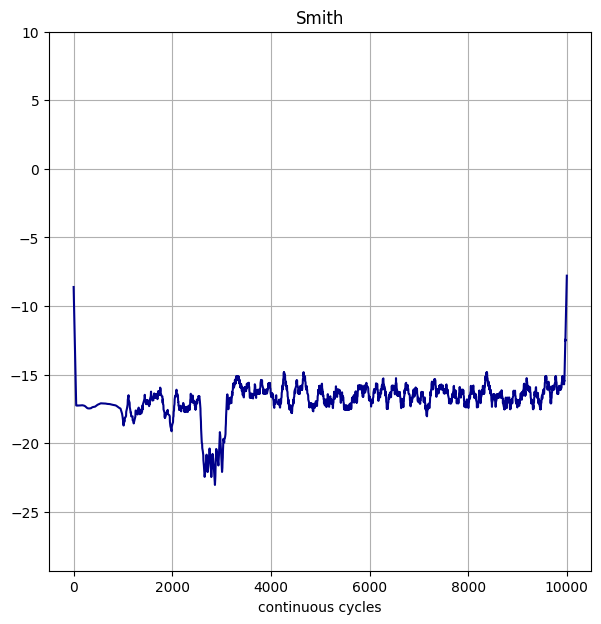

In [5]:
mem = training.get_results().ds_rewards
data_printing = {mem.names[0]: [False],
                 mem.names[1]: [False],
                 mem.names[2]: [False],
                 mem.names[3]: [False],
                 mem.names[4]: [True, 0, -1]}
mem_plot = DataPlotting(mem,
                        p_showing=plotting,
                        p_printing=data_printing,
                        p_type=DataPlotting.C_PLOT_TYPE_EP,
                        p_window=100)
mem_plot.get_plots()